# Search for Parameters That Maximize the Hill Number

### This notebook utilizes the solution to the reaction scheme matrix, obtained from the "solve_EA2B_matrix" script.
### It randomly generates several million sets of rate constants.
### For each parameter set, the reaction velocity is calculated against the concentration of ligand A and fitted to the Hill equation to analyze the cooperative behavior.

## 01 imports and initial setup

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool 
import sympy as sp
from sympy import symbols


In [ ]:

# Hill equation
def hill_eq(X, vmax, Kd, n):
    return (vmax * X**n) / (Kd**n + X**n)


A_vals = np.linspace(0.1, 2000, 1000)  # Avoid division by zero by starting at 0.1

# Storage for maximum Hill coefficients
max_hill_parameters = []



# Preallocate for tracking the best Hill coefficient
max_hill = 1;
max_vmax = 0;
best_fit_params = [];

best_fit_data = {}  
iterations_data = []

# A function to calculate fit quality metrics
def compute_fit_metrics(A_vals, V_vals, fit_params):
    predicted_vals = hill_eq(A_vals, *fit_params)
    residuals = V_vals - predicted_vals
    RSS = np.sum(residuals**2)  # Residual Sum of Squares
    TSS = np.sum((V_vals - np.mean(V_vals))**2)  # Total Sum of Squares
    R_squared = 1 - (RSS / TSS) if TSS > 0 else 0
    return RSS, R_squared

## Set parameter values for testing

In [ ]:

a = 1;
b = 0.1; # controlles internal hill value (low b creates high hill)
B = 100; # concentration of the second substrate
ET = 0.1; #total concentration of the enzyme

bound = 1e10  # A large number to approximate infinity
param_bounds = {
"k1"   :      (0,bound),
"k_1"  :      (0,bound),
"k_2"  :      (0,bound),
"k3"   :      (0,bound),
"k_3"  :      (0,bound),
"k_4"  :      (0,bound),
"k5"   :      (0,bound),
"k_5"  :      (0,bound),
"k6"   :      (0,bound),
"k_6"  :      (0,bound),
"k7"   :      (0,bound),
"B"    :        1.0e+02,
"ET"   :        1.0e-01,
"a"    :              1,
"b"    :            0.1,

}
    

# Vectorized sampling
num_samples = 1000000

# Separate fixed and sampled bounds
fixed_params = {}
sampled_bounds = {}

for key, val in param_bounds.items():
    if isinstance(val, tuple):
        sampled_bounds[key] = val
    else:
        fixed_params[key] = np.full(num_samples, val)  # Repeat fixed value across all samples

# Sample only the ones with ranges
sampled_params = {key: np.random.uniform(low, high, num_samples) for key, (low, high) in sampled_bounds.items()}

# Combine both
params = {**sampled_params, **fixed_params}


## Coefficient calculations

In [ ]:
  


P1 = params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**3*params['k_1']**3*params['k_5']**2

P2 = params['B']**2*params['ET']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']**2*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['ET']*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**2 + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**3*params['k_1']**3*params['k_2']*params['k_5']**2

P3 = params['B']**3*params['ET']*params['a']**2*params['k1']**3*params['k3']*params['k5']**3*params['k6']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['ET']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['ET']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['ET']*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['ET']*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['ET']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6']

P4 = params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**3*params['k_1']**3*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**3*params['k7']*params['k_1']**3*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**3*params['k_1']**3*params['k_5']**3

P5 = params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']**2*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']*params['k6']**2*params['k_1']*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**3*params['k_1']**3*params['k_2']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**3*params['k7']*params['k_1']**3*params['k_5']**2 + params['B']*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**2*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**3*params['k7']*params['k_1']**3*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**2*params['k7']*params['k_1']**3*params['k_4']*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**3 + params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**2*params['k_6'] + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**3*params['k7']*params['k_1']**3*params['k_2']*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**3*params['k_1']**3*params['k_2']*params['k_5']**3 + params['b']**3*params['k1']*params['k3']**2*params['k6']**3*params['k7']*params['k_1']**4*params['k_5']**2 + params['b']**3*params['k1']*params['k3']**2*params['k6']**3*params['k_1']**4*params['k_5']**3

P6 = params['B']**3*params['a']**2*params['k1']**3*params['k3']*params['k5']**3*params['k6']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']**2*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['k1']**3*params['k3']*params['k5']**2*params['k6']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']**2*params['k5']**2*params['k6']*params['k_1']**2*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']**2*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']*params['k3']**2*params['k5']**2*params['k6']**2*params['k7']*params['k_1']**2*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']*params['k_1']**3*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']**2*params['k5']*params['k6']*params['k_1']**3*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_4']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**3*params['k7']*params['k_1']**3*params['k_2']*params['k_5']**2 + params['B']*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_4']*params['k_5']**2 + params['B']*params['b']**2*params['k1']*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**3*params['k7']*params['k_1']**3*params['k_2']*params['k_5']**2 + params['B']*params['b']**2*params['k3']**2*params['k5']*params['k6']**3*params['k7']*params['k_1']**4*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**3 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**3 + params['a']*params['b']**2*params['k1']**2*params['k3']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k1']*params['k3']**2*params['k6']**2*params['k7']*params['k_1']**4*params['k_4']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']**2*params['k6']**2*params['k_1']**4*params['k_4']*params['k_5']**3 + params['b']**3*params['k1']*params['k3']**2*params['k6']**2*params['k_1']**4*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k1']*params['k3']*params['k6']**3*params['k7']*params['k_1']**4*params['k_2']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']*params['k6']**3*params['k_1']**4*params['k_2']*params['k_5']**3 + params['b']**3*params['k3']**2*params['k6']**3*params['k7']*params['k_1']**5*params['k_5']**2 + params['b']**3*params['k3']**2*params['k6']**3*params['k_1']**5*params['k_5']**3

P7 = params['B']**3*params['a']**2*params['k1']**3*params['k3']*params['k5']**3*params['k7']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**3*params['a']**2*params['k1']**3*params['k3']*params['k5']**3*params['k_2']*params['k_3']*params['k_4']*params['k_6']**3 + params['B']**3*params['a']**2*params['k1']**3*params['k5']**3*params['k6']*params['k7']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k3']*params['k5']**2*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**3 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']**2*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']**2*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k_1']**2*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k3']*params['k5']**2*params['k6']*params['k_1']*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']**2*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']*params['k3']*params['k5']**2*params['k6']**2*params['k7']*params['k_1']**2*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k3']*params['k5']*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']**2*params['k_1']**3*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k3']**2*params['k5']*params['k6']**2*params['k7']*params['k_1']**4*params['k_4']*params['k_5']**2 + params['B']*params['b']**2*params['k3']**2*params['k5']*params['k6']**2*params['k_1']**4*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**3*params['k7']*params['k_1']**4*params['k_2']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k7']*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k7']*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**2 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**3 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**3 + params['b']**3*params['k1']*params['k3']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k3']**2*params['k6']**2*params['k7']*params['k_1']**5*params['k_4']*params['k_5']**2 + params['b']**3*params['k3']**2*params['k6']**2*params['k_1']**5*params['k_4']*params['k_5']**3 + params['b']**3*params['k3']**2*params['k6']**2*params['k_1']**5*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k3']*params['k6']**3*params['k7']*params['k_1']**5*params['k_2']*params['k_5']**2 + params['b']**3*params['k3']*params['k6']**3*params['k_1']**5*params['k_2']*params['k_5']**3

P8 = params['B']**3*params['a']**2*params['k1']**3*params['k5']**3*params['k7']*params['k_2']*params['k_3']**2*params['k_4']*params['k_6']**2 + params['B']**3*params['a']**2*params['k1']**3*params['k5']**3*params['k_2']*params['k_3']**2*params['k_4']*params['k_6']**3 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k7']*params['k_1']*params['k_2']*params['k_3']**2*params['k_4']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k_1']*params['k_2']*params['k_3']**2*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']**2*params['b']*params['k1']**3*params['k5']**2*params['k_1']*params['k_2']*params['k_3']**2*params['k_4']*params['k_6']**3 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']**2*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_3']**2*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']**2*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']**2*params['a']*params['b']*params['k1']*params['k3']*params['k5']**2*params['k6']*params['k7']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']**2*params['a']*params['b']*params['k1']*params['k3']*params['k5']**2*params['k6']*params['k_1']**2*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_3']**2*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']**2*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']**2*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']**2*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']*params['k7']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']**2*params['k_6'] + params['B']*params['a']*params['b']**2*params['k1']*params['k3']*params['k5']*params['k6']*params['k_1']**3*params['k_2']*params['k_3']*params['k_4']*params['k_5']*params['k_6']**2 + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**2 + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**2*params['k7']*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**2 + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['B']*params['b']**2*params['k3']*params['k5']*params['k6']**2*params['k_1']**4*params['k_2']*params['k_4']*params['k_5']**2*params['k_6'] + params['b']**3*params['k3']*params['k6']**2*params['k7']*params['k_1']**5*params['k_2']*params['k_3']*params['k_5']**2 + params['b']**3*params['k3']*params['k6']**2*params['k7']*params['k_1']**5*params['k_2']*params['k_4']*params['k_5']**2 + params['b']**3*params['k3']*params['k6']**2*params['k_1']**5*params['k_2']*params['k_3']*params['k_5']**3 + params['b']**3*params['k3']*params['k6']**2*params['k_1']**5*params['k_2']*params['k_3']*params['k_5']**2*params['k_6'] + params['b']**3*params['k3']*params['k6']**2*params['k_1']**5*params['k_2']*params['k_4']*params['k_5']**3 + params['b']**3*params['k3']*params['k6']**2*params['k_1']**5*params['k_2']*params['k_4']*params['k_5']**2*params['k_6']








## Equation calculation

In [ ]:


A_vals = np.array(A_vals)


V_vals = (
    P1[:, None] * A_vals**4 +
     P2[:, None] * A_vals**3 +
     P3[:, None] * A_vals**2 
) / (
    P4[:, None] * A_vals**4 +
     P5[:, None] * A_vals**3 +
     P6[:, None] * A_vals**2 +
     P7[:, None] * A_vals +
     P8[:, None]
)





## Fit Hill equation for one sample of set of parameters

In [ ]:

def fit_sample(sample_data):
    A_vals, V_sample, idx = sample_data
    
    # Initial guess for Hill parameters
    hill_params_guess = [np.max(V_sample), np.median(A_vals), 1]
    
    try:
        # Fit Hill equation
        fit_params, _ = curve_fit(hill_eq, A_vals, V_sample, p0=hill_params_guess)
        vmax_fit, Kd_fit, n_fit = fit_params
        
        # Compute fit quality metrics
        RSS, R_squared = compute_fit_metrics(A_vals, V_sample, fit_params)
        
        # Return fit results and metrics
        return {
            "Iteration": idx,
            "vmax_fit": vmax_fit,
            "Kd_fit": Kd_fit,
            "n_fit": n_fit,
            "RSS": RSS,
            "R_squared": R_squared
        }
    except RuntimeError as e:
        return {
        }

# Prepare data for parallel processing
samples_data = [(A_vals, V_vals[i, :], i) for i in range(V_vals.shape[0])]

# Use multiprocessing for parallel fitting
with Pool() as pool:
    results = pool.map(fit_sample, samples_data)



## Convert results to a DataFrame and filter by quality of the fit

In [20]:

results_df = pd.DataFrame(results)
params_df = pd.DataFrame(params)
results_df = pd.concat([results_df, params_df], axis=1)


In [21]:
columns_order = ["Iteration", "n_fit", "RSS", "R_squared", "vmax_fit", "Kd_fit", 
                 "k1", "k_1", "k_2", "k3", "k_3", "k_4", "k5", "k_5", "k6", "k_6", "k7", "a", "b", "B", "ET"]
results_df = results_df[columns_order]
results_df.set_index("Iteration", inplace=True) 

#filltering options
results_df_filltered = results_df[results_df['R_squared'] >= 0.98].copy()
results_df_filltered = results_df_filltered[results_df_filltered['RSS'] <= 1e-6].copy()
#aditional options
#results_df_filltered = results_df_filltered[results_df_filltered['Kd_fit'] <= 10000].copy()
#results_df_filltered = results_df_filltered[results_df_filltered['vmax_fit'] >= 0.0001].copy()

#Sorting by 'n_fit'
results_df_filltered.sort_values(by="n_fit", ascending=False, inplace=True)

results_df_filltered.head(200)
#results_df_filltered.head(200).to_csv('path_to_desired_location.csv', index=False)


,n_fit,RSS,R_squared,vmax_fit,Kd_fit,k1,k_1,k_2,k3,k_3,k_4,k5,k_5,k6,k_6,k7,a,b,B,ET
Iteration,,,,,,,,,,,,,,,,,,,,
59255.0,2.965177,5.442292e-07,0.996004,0.011602,1.310683,3.047013e+09,5.014551e+09,1.725377e+09,4.472171e+09,7.988691e+09,6.743019e+09,2.381721e+07,9.629676e+09,8.382727e+09,5.425636e+09,8.538278e+09,1,0.1,100.0,0.1
53924.0,2.499622,5.272837e-07,0.991126,0.007165,1.742382,1.502640e+09,6.917115e+09,7.578422e+09,9.720994e+09,6.243585e+09,8.198682e+09,8.519645e+06,6.409568e+09,4.203530e+09,6.625290e+09,4.651539e+09,1,0.1,100.0,0.1
84612.0,2.453640,4.182878e-07,0.996835,0.011185,1.394611,4.050108e+09,9.071879e+09,3.620137e+09,5.790303e+09,6.598060e+09,6.946519e+09,2.253138e+07,9.488401e+09,3.746038e+09,3.694304e+09,8.422973e+09,1,0.1,100.0,0.1
10985.0,2.412146,3.345211e-12,0.999996,0.001170,0.165665,8.557264e+09,4.061287e+09,3.405454e+09,6.691162e+09,7.632210e+09,8.887658e+08,1.456538e+06,7.259553e+09,6.636760e+09,1.923453e+09,5.047016e+09,1,0.1,100.0,0.1
63818.0,2.127989,1.145494e-08,0.999820,0.007975,0.994824,2.723476e+09,5.761400e+09,7.061943e+09,2.600857e+09,8.686856e+09,3.042632e+09,7.960652e+06,5.715785e+09,7.605767e+09,2.729965e+09,3.472279e+09,1,0.1,100.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8581.0,1.346743,2.287729e-07,0.998134,0.010970,0.860005,6.894754e+09,8.669246e+09,2.514609e+09,3.195741e+09,6.621601e+09,8.395932e+09,2.178030e+07,7.915578e+09,7.005493e+09,5.095848e+07,9.748525e+09,1,0.1,100.0,0.1
28387.0,1.343296,6.761255e-07,0.999955,0.098348,2.523552,9.335145e+09,3.891893e+09,4.815622e+07,1.818386e+09,3.378441e+09,7.336134e+08,6.206623e+09,7.648985e+09,3.566899e+09,5.058416e+08,2.584560e+09,1,0.1,100.0,0.1
12796.0,1.341749,9.539599e-07,0.999838,0.087306,0.411541,6.985386e+09,9.169859e+09,7.364762e+09,9.766977e+09,1.280439e+09,9.277978e+09,3.126633e+08,4.071106e+09,8.244433e+09,8.649466e+08,4.693291e+08,1,0.1,100.0,0.1


In [23]:
#statistics of the results
results_df.describe()


,n_fit,RSS,R_squared,vmax_fit,Kd_fit,k1,k_1,k_2,k3,k_3,k_4,k5,k_5,k6,k_6,k7,a,b,B,ET
count,99071.000000,9.907100e+04,99071.000000,99071.000000,9.907100e+04,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,100000.0,1.000000e+05,100000.0,1.000000e+05
mean,1.104511,9.067778e-05,0.994576,0.096673,3.450754e+08,4.992895e+09,4.996046e+09,4.997079e+09,5.003110e+09,5.002712e+09,5.030683e+09,4.977470e+09,5.006556e+09,4.997130e+09,5.023055e+09,5.001766e+09,1.0,1.000000e-01,100.0,1.000000e-01
std,0.181278,7.256195e-04,0.046748,0.007658,8.440252e+10,2.887166e+09,2.880065e+09,2.883262e+09,2.877823e+09,2.890764e+09,2.885202e+09,2.882290e+09,2.889945e+09,2.885527e+09,2.887913e+09,2.895114e+09,0.0,1.884752e-13,0.0,1.884752e-13
min,-1.820664,1.716668e-13,0.000181,0.000074,1.862924e-25,9.650865e+04,2.280270e+04,2.479279e+04,2.971653e+05,1.033972e+05,8.425628e+04,3.471580e+04,7.832105e+03,2.886099e+05,9.941069e+04,1.274131e+05,1.0,1.000000e-01,100.0,1.000000e-01
25%,1.042781,7.362058e-06,0.998858,0.097154,2.675664e+00,2.492748e+09,2.503998e+09,2.505593e+09,2.519126e+09,2.499227e+09,2.537766e+09,2.473429e+09,2.500023e+09,2.494356e+09,2.519215e+09,2.486946e+09,1.0,1.000000e-01,100.0,1.000000e-01
50%,1.090705,1.301086e-05,0.999430,0.098610,4.483870e+00,4.985459e+09,5.006251e+09,4.988751e+09,5.021109e+09,5.002490e+09,5.050620e+09,4.959207e+09,5.008231e+09,4.992376e+09,5.043840e+09,5.011193e+09,1.0,1.000000e-01,100.0,1.000000e-01
75%,1.154424,2.837607e-05,0.999727,0.099245,8.862034e+00,7.493055e+09,7.489002e+09,7.477454e+09,7.492702e+09,7.507547e+09,7.540780e+09,7.468878e+09,7.524842e+09,7.483915e+09,7.534712e+09,7.515155e+09,1.0,1.000000e-01,100.0,1.000000e-01
max,6.231087,3.468743e-02,1.000000,0.419864,2.627443e+13,9.999908e+09,9.999764e+09,9.999917e+09,9.999941e+09,9.999841e+09,9.999983e+09,9.999954e+09,9.999923e+09,9.999888e+09,9.999959e+09,9.999948e+09,1.0,1.000000e-01,100.0,1.000000e-01


## examine individual set of parameters by iteration number

/tmp/ipykernel_334568/2652376705.py:3: RuntimeWarning: invalid value encountered in scalar power
  return (vmax * X**n) / (Kd**n + X**n)


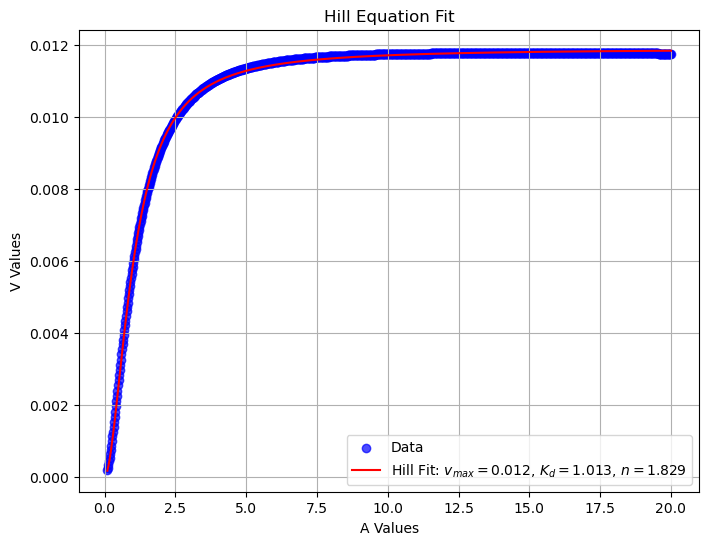

vmax_fit: 0.012
Kd_fit: 1.013
n_fit: 1.829
k1     3.047013e+09
k_1    5.014551e+09
k_2    1.725377e+09
k3     4.472171e+09
k_3    7.988691e+09
k_4    6.743019e+09
k5     2.381721e+07
k_5    9.629676e+09
k6     8.382727e+09
k_6    5.425636e+09
k7     8.538278e+09
Name: 59255.0, dtype: float64


In [24]:
#looking into the quality of the fit by the iteration number

A_vals_2= np.linspace(0.1, 20, 1000)  
iteration_dat = results_df_filltered.loc[1] #number of iteration you wish to inspect (1 is an example)



# Definition of all symbols
A, B, ET, a, b = symbols('A B ET a b')
k1, k3, k5, k6 = symbols('k1 k3 k5 k6')
k_1, k_2, k_3, k_4, k_5, k_6 = symbols('k_1 k_2 k_3 k_4 k_5 k_6')

k_symbols = {}
for i in range(1, 9):  
    k_symbols[f'k{i}'] = symbols(f'k{i}')
    k_symbols[f'k_{i}'] = symbols(f'k_{i}')

locals().update(k_symbols)


# Parameters calculations
for param in iteration_dat.index:
    globals()[param] = iteration_dat[param]

    
    P1 = B*ET*a*b**2*k1**2*k3**2*k5*k6**3*k_1**3*k_5**2
    P2 = (B**2*ET*a**2*b*k1**3*k3*k5**2*k6**2*k_1*k_2*k_3*k_5*k_6 + B**2*ET*a*b*k1**2*k3**2*k5**2*k6**2*k_1**2*k_4*k_5*k_6 + B*ET*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_4*k_5**2 + B*ET*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_4*k_5*k_6 + B*ET*a*b**2*k1**2*k3*k5*k6**3*k_1**3*k_2*k_5**2)
    P3 = (B**3*ET*a**2*k1**3*k3*k5**3*k6*k_2*k_3*k_4*k_6**2 + B**2*ET*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_5*k_6 + B**2*ET*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_6**2 + B**2*ET*a*b*k1**2*k3*k5**2*k6**2*k_1**2*k_2*k_3*k_5*k_6 + B**2*ET*a*b*k1**2*k3*k5**2*k6**2*k_1**2*k_2*k_4*k_5*k_6 + B*ET*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_3*k_5**2 + B*ET*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_3*k_5*k_6 + B*ET*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_4*k_5**2 + B*ET*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_4*k_5*k_6)
    P4 = (B*a*b**2*k1**2*k3**2*k5*k6**3*k_1**3*k_5**2 + a*b**2*k1**2*k3**2*k6**3*k7*k_1**3*k_5**2 + a*b**2*k1**2*k3**2*k6**3*k_1**3*k_5**3)
    P5 = (B**2*a**2*b*k1**3*k3*k5**2*k6**2*k_1*k_2*k_3*k_5*k_6 + B**2*a*b*k1**2*k3**2*k5**2*k6**2*k_1**2*k_4*k_5*k_6 + B*a**2*b*k1**3*k3*k5*k6**2*k_1*k_2*k_3*k_5**2*k_6 + B*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_4*k_5**2 + B*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_4*k_5*k_6 + B*a*b**2*k1**2*k3**2*k5*k6**2*k_1**3*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6**3*k_1**3*k_2*k_5**2 + B*a*b**2*k1*k3**2*k5*k6**3*k7*k_1**3*k_5**2 + B*a*b*k1**2*k3**2*k5*k6**2*k_1**2*k_4*k_5**2*k_6 + B*b**2*k1*k3**2*k5*k6**3*k7*k_1**3*k_5**2 + a*b**2*k1**2*k3**2*k6**2*k7*k_1**3*k_4*k_5**2 + a*b**2*k1**2*k3**2*k6**2*k_1**3*k_4*k_5**3 + a*b**2*k1**2*k3**2*k6**2*k_1**3*k_4*k_5**2*k_6 + a*b**2*k1**2*k3*k6**3*k7*k_1**3*k_2*k_5**2 + a*b**2*k1**2*k3*k6**3*k_1**3*k_2*k_5**3 + b**3*k1*k3**2*k6**3*k7*k_1**4*k_5**2 + b**3*k1*k3**2*k6**3*k_1**4*k_5**3)
    P6 = (B**3*a**2*k1**3*k3*k5**3*k6*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k6*k7*k_1*k_2*k_3*k_5*k_6 + B**2*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_5*k_6 + B**2*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k6*k_1*k_2*k_3*k_5*k_6**2 + B**2*a**2*b*k1**3*k5**2*k6**2*k7*k_1*k_2*k_3*k_5*k_6 + B**2*a**2*k1**3*k3*k5**2*k6*k_2*k_3*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k3**2*k5**2*k6*k7*k_1**2*k_4*k_5*k_6 + B**2*a*b*k1**2*k3**2*k5**2*k6*k_1**2*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6**2*k_1**2*k_2*k_3*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6**2*k_1**2*k_2*k_4*k_5*k_6 + B**2*a*b*k1*k3**2*k5**2*k6**2*k7*k_1**2*k_4*k_5*k_6 + B*a**2*b*k1**3*k3*k5*k6*k7*k_1*k_2*k_3*k_4*k_5*k_6 + B*a**2*b*k1**3*k3*k5*k6*k_1*k_2*k_3*k_4*k_5**2*k_6 + B*a**2*b*k1**3*k3*k5*k6*k_1*k_2*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k3**2*k5*k6*k7*k_1**3*k_4*k_5*k_6 + B*a*b**2*k1**2*k3**2*k5*k6*k_1**3*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k3**2*k5*k6*k_1**3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_3*k_5**2 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_3*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_4*k_5**2 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_2*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**3*k_3*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6**2*k_1**2*k_2*k_3*k_5**2*k_6 + B*a*b**2*k1*k3**2*k5*k6**2*k7*k_1**3*k_4*k_5**2 + B*a*b**2*k1*k3**2*k5*k6**2*k7*k_1**3*k_4*k_5*k_6 + B*a*b**2*k1*k3*k5*k6**3*k7*k_1**3*k_2*k_5**2 + B*a*b*k1**2*k3*k5*k6**2*k_1**2*k_2*k_3*k_5**2*k_6 + B*a*b*k1**2*k3*k5*k6**2*k_1**2*k_2*k_4*k_5**2*k_6 + B*b**2*k1*k3**2*k5*k6**2*k7*k_1**3*k_4*k_5**2 + B*b**2*k1*k3**2*k5*k6**2*k_1**3*k_4*k_5**2*k_6 + B*b**2*k1*k3*k5*k6**3*k7*k_1**3*k_2*k_5**2 + B*b**2*k3**2*k5*k6**3*k7*k_1**4*k_5**2 + a*b**2*k1**2*k3*k6**2*k7*k_1**3*k_2*k_3*k_5**2 + a*b**2*k1**2*k3*k6**2*k7*k_1**3*k_2*k_4*k_5**2 + a*b**2*k1**2*k3*k6**2*k_1**3*k_2*k_3*k_5**3 + a*b**2*k1**2*k3*k6**2*k_1**3*k_2*k_3*k_5**2*k_6 + a*b**2*k1**2*k3*k6**2*k_1**3*k_2*k_4*k_5**3 + a*b**2*k1**2*k3*k6**2*k_1**3*k_2*k_4*k_5**2*k_6 + b**3*k1*k3**2*k6**2*k7*k_1**4*k_4*k_5**2 + b**3*k1*k3**2*k6**2*k_1**4*k_4*k_5**3 + b**3*k1*k3**2*k6**2*k_1**4*k_4*k_5**2*k_6 + b**3*k1*k3*k6**3*k7*k_1**4*k_2*k_5**2 + b**3*k1*k3*k6**3*k_1**4*k_2*k_5**3 + b**3*k3**2*k6**3*k7*k_1**5*k_5**2 + b**3*k3**2*k6**3*k_1**5*k_5**3)
    P7 = (B**3*a**2*k1**3*k3*k5**3*k7*k_2*k_3*k_4*k_6**2 + B**3*a**2*k1**3*k3*k5**3*k_2*k_3*k_4*k_6**3 + B**3*a**2*k1**3*k5**3*k6*k7*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k7*k_1*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k_1*k_2*k_3*k_4*k_5*k_6**2 + B**2*a**2*b*k1**3*k3*k5**2*k_1*k_2*k_3*k_4*k_6**3 + B**2*a**2*b*k1**3*k5**2*k6*k7*k_1*k_2*k_3**2*k_5*k_6 + B**2*a**2*b*k1**3*k5**2*k6*k7*k_1*k_2*k_3*k_4*k_5*k_6 + B**2*a**2*b*k1**3*k5**2*k6*k7*k_1*k_2*k_3*k_4*k_6**2 + B**2*a**2*b*k1**3*k5**2*k6*k_1*k_2*k_3**2*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6*k7*k_1**2*k_2*k_3*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6*k7*k_1**2*k_2*k_4*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6*k7*k_1**2*k_3*k_4*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6*k7*k_1*k_2*k_3*k_4*k_5*k_6 + B**2*a*b*k1**2*k3*k5**2*k6*k_1**2*k_2*k_3*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6*k_1**2*k_2*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6*k_1**2*k_3*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k3*k5**2*k6*k_1*k_2*k_3*k_4*k_5*k_6**2 + B**2*a*b*k1**2*k5**2*k6**2*k7*k_1**2*k_2*k_3*k_5*k_6 + B**2*a*b*k1*k3*k5**2*k6**2*k7*k_1**2*k_2*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k7*k_1**3*k_2*k_3*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k7*k_1**3*k_2*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k7*k_1**3*k_3*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k7*k_1**2*k_2*k_3*k_4*k_5*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_2*k_3*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_2*k_3*k_5*k_6**2 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_2*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_2*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_3*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**3*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k3*k5*k6*k_1**2*k_2*k_3*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k3*k5*k6*k_1**2*k_2*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k5*k6**2*k7*k_1**3*k_2*k_3*k_5*k_6 + B*a*b**2*k1**2*k5*k6**2*k_1**3*k_2*k_3*k_5**2*k_6 + B*a*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_3*k_5**2 + B*a*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_4*k_5**2 + B*a*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_4*k_5*k_6 + B*a*b**2*k1*k3*k5*k6**2*k_1**3*k_2*k_3*k_5**2*k_6 + B*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_3*k_5**2 + B*b**2*k1*k3*k5*k6**2*k7*k_1**3*k_2*k_4*k_5**2 + B*b**2*k1*k3*k5*k6**2*k_1**3*k_2*k_3*k_5**2*k_6 + B*b**2*k1*k3*k5*k6**2*k_1**3*k_2*k_4*k_5**2*k_6 + B*b**2*k3**2*k5*k6**2*k7*k_1**4*k_4*k_5**2 + B*b**2*k3**2*k5*k6**2*k_1**4*k_4*k_5**2*k_6 + B*b**2*k3*k5*k6**3*k7*k_1**4*k_2*k_5**2 + b**3*k1*k3*k6**2*k7*k_1**4*k_2*k_3*k_5**2 + b**3*k1*k3*k6**2*k7*k_1**4*k_2*k_4*k_5**2 + b**3*k1*k3*k6**2*k_1**4*k_2*k_3*k_5**3 + b**3*k1*k3*k6**2*k_1**4*k_2*k_3*k_5**2*k_6 + b**3*k1*k3*k6**2*k_1**4*k_2*k_4*k_5**3 + b**3*k1*k3*k6**2*k_1**4*k_2*k_4*k_5**2*k_6 + b**3*k3**2*k6**2*k7*k_1**5*k_4*k_5**2 + b**3*k3**2*k6**2*k_1**5*k_4*k_5**3 + b**3*k3**2*k6**2*k_1**5*k_4*k_5**2*k_6 + b**3*k3*k6**3*k7*k_1**5*k_2*k_5**2 + b**3*k3*k6**3*k_1**5*k_2*k_5**3)
    P8 = B**3*a**2*k1**3*k5**3*k7*k_2*k_3**2*k_4*k_6**2 + B**3*a**2*k1**3*k5**3*k_2*k_3**2*k_4*k_6**3 + B**2*a**2*b*k1**3*k5**2*k7*k_1*k_2*k_3**2*k_4*k_6**2 + B**2*a**2*b*k1**3*k5**2*k_1*k_2*k_3**2*k_4*k_5*k_6**2 + B**2*a**2*b*k1**3*k5**2*k_1*k_2*k_3**2*k_4*k_6**3 + B**2*a*b*k1**2*k5**2*k6*k7*k_1**2*k_2*k_3**2*k_5*k_6 + B**2*a*b*k1**2*k5**2*k6*k7*k_1**2*k_2*k_3*k_4*k_5*k_6 + B**2*a*b*k1**2*k5**2*k6*k_1**2*k_2*k_3**2*k_5*k_6**2 + B**2*a*b*k1**2*k5**2*k6*k_1**2*k_2*k_3*k_4*k_5*k_6**2 + B**2*a*b*k1*k3*k5**2*k6*k7*k_1**2*k_2*k_3*k_4*k_5*k_6 + B**2*a*b*k1*k3*k5**2*k6*k_1**2*k_2*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1**2*k5*k6*k7*k_1**3*k_2*k_3**2*k_5*k_6 + B*a*b**2*k1**2*k5*k6*k7*k_1**3*k_2*k_3*k_4*k_5*k_6 + B*a*b**2*k1**2*k5*k6*k_1**3*k_2*k_3**2*k_5**2*k_6 + B*a*b**2*k1**2*k5*k6*k_1**3*k_2*k_3**2*k_5*k_6**2 + B*a*b**2*k1**2*k5*k6*k_1**3*k_2*k_3*k_4*k_5**2*k_6 + B*a*b**2*k1**2*k5*k6*k_1**3*k_2*k_3*k_4*k_5*k_6**2 + B*a*b**2*k1*k3*k5*k6*k7*k_1**3*k_2*k_3*k_4*k_5*k_6 + B*a*b**2*k1*k3*k5*k6*k_1**3*k_2*k_3*k_4*k_5**2*k_6 + B*a*b**2*k1*k3*k5*k6*k_1**3*k_2*k_3*k_4*k_5*k_6**2 + B*b**2*k3*k5*k6**2*k7*k_1**4*k_2*k_3*k_5**2 + B*b**2*k3*k5*k6**2*k7*k_1**4*k_2*k_4*k_5**2 + B*b**2*k3*k5*k6**2*k_1**4*k_2*k_3*k_5**2*k_6 + B*b**2*k3*k5*k6**2*k_1**4*k_2*k_4*k_5**2*k_6 + b**3*k3*k6**2*k7*k_1**5*k_2*k_3*k_5**2 + b**3*k3*k6**2*k7*k_1**5*k_2*k_4*k_5**2 + b**3*k3*k6**2*k_1**5*k_2*k_3*k_5**3 + b**3*k3*k6**2*k_1**5*k_2*k_3*k_5**2*k_6 + b**3*k3*k6**2*k_1**5*k_2*k_4*k_5**3 + b**3*k3*k6**2*k_1**5*k_2*k_4*k_5**2*k_6

    
# Equation calculation
V_expr = (P1*A**4 + P2*A**3 + P3*A**2) / (P4*A**4 + P5*A**3 + P6*A**2 + P7*A + P8)

V_func = sp.lambdify(A, V_expr, 'numpy')

V_vals = V_func(A_vals_2)

# Fit Hill equation
hill_params_guess = [np.max(V_vals), np.median(A_vals_2), 1]  # Initial guesses for vmax, Kd, and n
fit_params, _ = curve_fit(hill_eq, A_vals_2, V_vals, p0=hill_params_guess)

# Extract fitted parameters
vmax_fit, Kd_fit, n_fit = fit_params

# Generate Hill equation curve for plotting
A_fit = np.linspace(min(A_vals_2), max(A_vals_2), 500)
V_fit = hill_eq(A_fit, vmax_fit, Kd_fit, n_fit)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(A_vals_2, V_vals, label='Data', color='blue', alpha=0.7)
plt.plot(A_fit, V_fit, label=f'Hill Fit: $v_{{max}}={vmax_fit:.3f}$, $K_d={Kd_fit:.3f}$, $n={n_fit:.3f}$', color='red')
plt.xlabel('A Values')
plt.ylabel('V Values')
plt.title('Hill Equation Fit')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted values for vmax, Kd, and n
print(f"vmax_fit: {vmax_fit:.3f}")
print(f"Kd_fit: {Kd_fit:.3f}")
print(f"n_fit: {n_fit:.3f}")

# List of coefficient parameters
coefficient_params = ['k1', 'k_1', 'k_2', 'k3', 'k_3', 'k_4', 'k5', 'k_5', 'k6', 'k_6', 'k7']
iteration_dat_rounded = iteration_dat.round(3)
coefficient_values = iteration_dat_rounded[coefficient_params]

# Print the coefficient values
print(coefficient_values)


